## Load the data
* Exract `Abstract` and `Titles`

In [1]:
# Load data from Hugging Face
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Steps for text clustering

1. Convert the input documents to embeddings with an embedding
model.
2. Reduce the dimensionality of embeddings with a dimensionality
reduction model.
3. Find groups of semantically similar documents with a cluster
model.

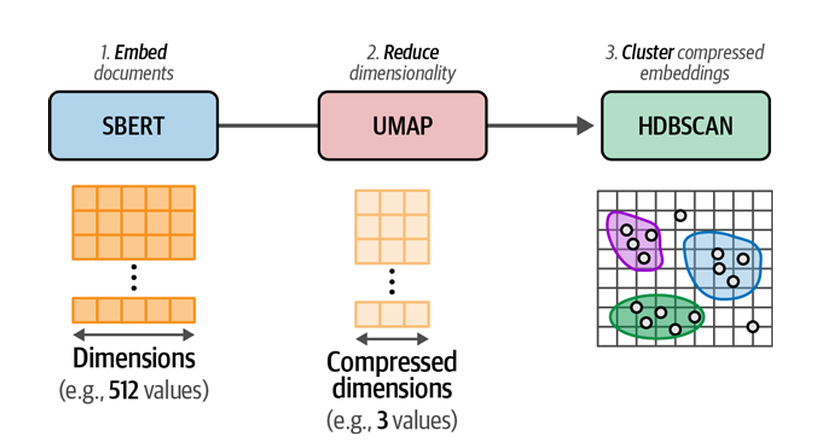


## Step 1. Convert input into Embeddings

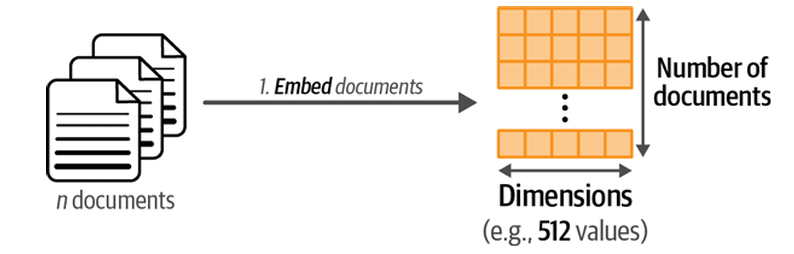

In [2]:
from sentence_transformers import SentenceTransformer
# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts,
show_progress_bar=
True
)


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [3]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## step 2. Redusing the Dimensionality using `Uniform Manifold Approximation and Projection (UMAP)`.

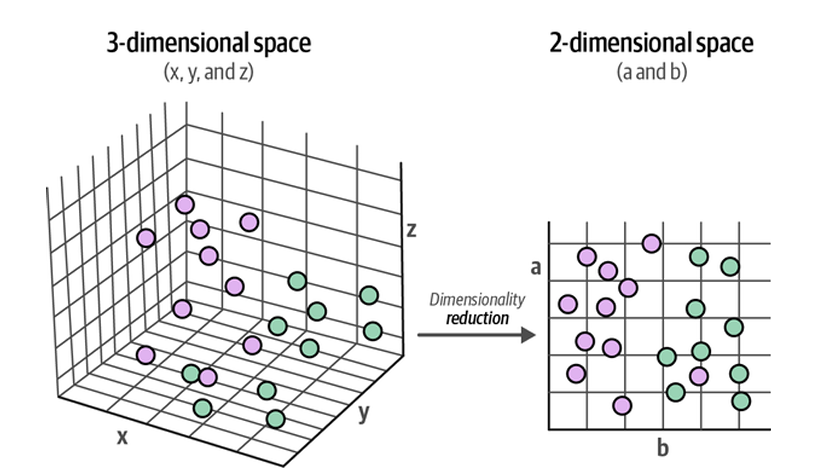

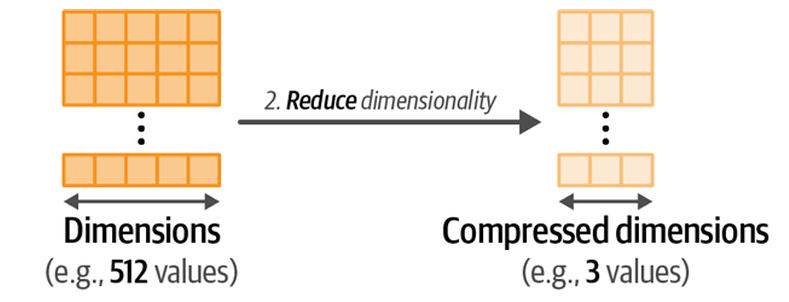

In [4]:
from umap import UMAP
# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
      n_components=5,  # decide the shape of the lower-dimensional space (Generally, values between5 and 10 work well to capture high-dimensional global structures.)
      min_dist=0.0,    #  minimum distance between embedded points.  We are setting this to 0 as that generally results in tighter clusters.
      metric='cosine',
      random_state=42
  )
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [5]:
reduced_embeddings.shape

(44949, 5)

## Step 3. Clustering the reduced embeddings

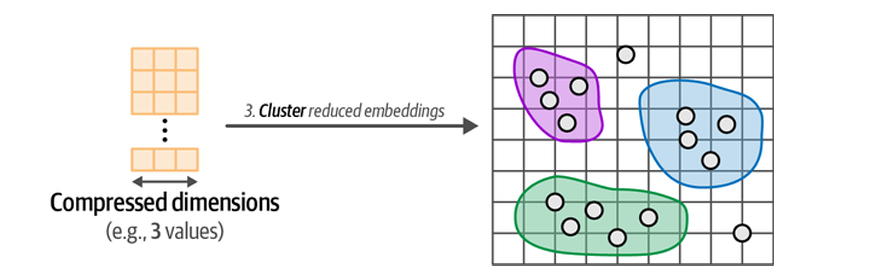

In [6]:
from hdbscan import HDBSCAN
# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50,
    metric="euclidean",
    cluster_selection_method="eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


155

## Inspecting the Clusters

In [7]:
import numpy as np
# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[int(index)][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



## To visualize the clusters we need 2 dimensional embeddings

In [8]:
import pandas as pd
# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2,
    min_dist=0.0,
    metric="cosine",
    random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(np.float64(-8.334335255622864),
 np.float64(11.817492890357972),
 np.float64(-5.973596382141113),
 np.float64(11.185701179504395))

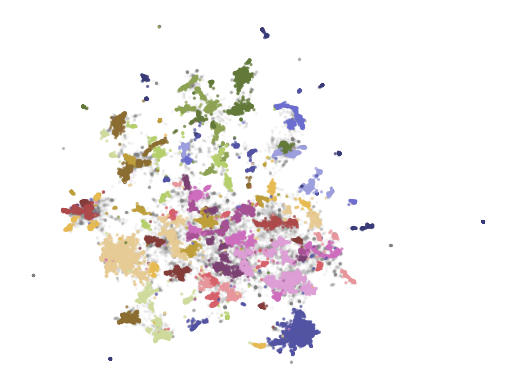

In [9]:
import matplotlib.pyplot as plt
# Plot outliers and non-outliers separately
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")

plt.scatter(
  to_plot.x,
  to_plot.y,
  c=to_plot.cluster.astype(int),
  alpha=0.6,
  s=2,
  cmap="tab20b"
)

plt.axis("off")

# Text Clustering to Topic Modeling

In [10]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.1 MB/s eta 0:00:00


In [11]:
from bertopic import BERTopic
# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
verbose=
True
).fit(abstracts, embeddings)

2026-01-12 08:01:32,701 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-12 08:02:51,647 - BERTopic - Dimensionality - Completed ✓
2026-01-12 08:02:51,650 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-12 08:02:57,066 - BERTopic - Cluster - Completed ✓
2026-01-12 08:02:57,105 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-12 08:03:11,374 - BERTopic - Representation - Completed ✓


In [12]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14210,-1_of_the_and_to,"[of, the, and, to, in, we, language, for, that...",[ GPT-$3$ has attracted lots of attention due...
1,0,2316,0_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...",[ The speech chain mechanism integrates autom...
2,1,2183,1_question_qa_questions_answer,"[question, qa, questions, answer, answering, a...",[ Text-based Question Generation (QG) aims at...
3,2,941,2_translation_nmt_machine_bleu,"[translation, nmt, machine, bleu, neural, engl...","[ Recently, the development of neural machine..."
4,3,880,3_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Sentence summarization shortens given texts...
...,...,...,...,...,...
150,149,54,149_sentence_embeddings_sts_embedding,"[sentence, embeddings, sts, embedding, similar...",[ Sentence representation at the semantic lev...
151,150,54,150_gans_gan_adversarial_generation,"[gans, gan, adversarial, generation, generativ...",[ Text generation is of particular interest i...
152,151,54,151_coherence_discourse_paragraph_text,"[coherence, discourse, paragraph, text, cohesi...",[ While there has been significant progress t...
153,152,53,152_chatgpt_its_openai_tasks,"[chatgpt, its, openai, tasks, has, ai, capabil...","[ Over the last few years, large language mod..."


In [13]:
topic_model.get_topic(0)

[('speech', np.float64(0.028208883288593535)),
 ('asr', np.float64(0.018842312810416793)),
 ('recognition', np.float64(0.01351959051292077)),
 ('end', np.float64(0.009745990895354896)),
 ('acoustic', np.float64(0.009384710004108402)),
 ('speaker', np.float64(0.006877359138616964)),
 ('audio', np.float64(0.006785262733110495)),
 ('the', np.float64(0.006370412745274845)),
 ('error', np.float64(0.00634287314665723)),
 ('automatic', np.float64(0.0063065026437668335))]

In [14]:
topic_model.find_topics("topic modeling")

([24, -1, 38, 32, 84],
 [np.float32(0.9545274),
  np.float32(0.9123676),
  np.float32(0.9080541),
  np.float32(0.9053283),
  np.float32(0.90453553)])

In [15]:
topic_model.get_topic(24)

[('topic', np.float64(0.06811153301756999)),
 ('topics', np.float64(0.035746717561104396)),
 ('lda', np.float64(0.016020062969070364)),
 ('latent', np.float64(0.013574936227317968)),
 ('documents', np.float64(0.013201698266173009)),
 ('document', np.float64(0.012912590658853182)),
 ('modeling', np.float64(0.012084716289729468)),
 ('dirichlet', np.float64(0.01010281253111858)),
 ('word', np.float64(0.008653858081603273)),
 ('allocation', np.float64(0.007950503995528465))]

In [16]:
topic_model.topics_[titles.index("BERTopic: Neural topic modeling with a class-based TF-IDF procedure")]

24

In [19]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    docs=list(titles), # Convert titles to a list of strings
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)
# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

In [21]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

In [18]:
# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

In [22]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [24]:
def topic_differences(model, original_topics, nr_topics=5):
  """Show the differences in topic representations between two models """
  df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
  for topic in range(nr_topics):
    # Extract top 5 words per topic per model
    og_words = " | ".join(list(zip(*original_topics[topic]))
    [0][:5])
    new_words = " | ".join(list(zip(*model.get_topic(topic)))
    [0][:5])
    df.loc[len(df)] = [topic, og_words, new_words]
  return df

In [25]:
from bertopic.representation import KeyBERTInspired
# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts,
representation_model=representation_model)


In [26]:
# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,phonetic | encoder | transcription | speech | ...
1,1,question | qa | questions | answer | answering,answering | comprehension | questions | questi...
2,2,translation | nmt | machine | bleu | neural,translation | translate | translations | trans...
3,3,summarization | summaries | summary | abstract...,summarization | summarizers | summaries | summ...
4,4,hate | offensive | speech | detection | toxic,hate | hateful | language | offensive | languages


In [27]:
from bertopic.representation import MaximalMarginalRelevance
# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts,
representation_model=representation_model)


In [28]:
# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,speech | asr | audio | error | automatic
1,1,question | qa | questions | answer | answering,questions | retrieval | comprehension | passag...
2,2,translation | nmt | machine | bleu | neural,translation | nmt | bleu | neural | parallel
3,3,summarization | summaries | summary | abstract...,summarization | summaries | extractive | docum...
4,4,hate | offensive | speech | detection | toxic,hate | offensive | toxic | abusive | hateful


In [30]:
from transformers import pipeline
from bertopic.representation import TextGeneration
prompt = """I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the documents and keywords, what is this topic about?"""
# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model="google/flan-t5-small")
representation_model = TextGeneration(
generator, prompt=prompt, doc_length=50,
tokenizer="whitespace"
)
topic_model.update_topics(abstracts,
representation_model=representation_model)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
100%|██████████| 155/155 [02:57<00:00,  1.15s/it]


In [31]:
# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,Speech-to-speech synthesis | | | |
1,1,question | qa | questions | answer | answering,Question answering systems | | | |
2,2,translation | nmt | machine | bleu | neural,Science/Tech | | | |
3,3,summarization | summaries | summary | abstract...,Document summarization | | | |
4,4,hate | offensive | speech | detection | toxic,Science/Tech | | | |
